In [92]:
!pip install xgboost



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [93]:
#import all dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
#import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

from sklearn.utils import resample

#from sklearn.model_selection import GridSearchCV

import joblib #for exporting to .pkl and importing the model to the notebook


#from sklearn.metrics import mean_squared_error

# **Data Pre Processing** #


In [94]:
df = pd.read_csv('../Data/bookings_train.csv')

In [95]:
df. head(10000)

,booking_id,citizen_id,booking_date,appointment_date,appointment_time,check_in_time,check_out_time,task_id,num_documents,queue_number,satisfaction_rating
0,f7b59ba3793fea61282cb02be2247cebd0a75306,4229044420,2021-01-01,2021-01-01,09:03,2021-01-01 09:11:00,2021-01-01 09:48:15.166353269,TASK-002,0,2,4
1,cfe30d53b4b645e4cb6b114f6c9d74a0f25e6a80,5389442635,2021-01-01,2021-01-01,09:12,2021-01-01 09:24:00,2021-01-01 10:24:12.189261137,TASK-001,1,1,4
2,0fb0a5d9b3944dd743a9e7828dc03fa74aa6ebf8,2123783919,2021-01-01,2021-01-01,09:36,2021-01-01 09:29:00,2021-01-01 10:26:48.802260864,TASK-002,1,6,5
3,d4bf826153212fa325ad98b215668ab942365607,6359918966,2021-01-01,2021-01-01,09:45,2021-01-01 10:07:00,2021-01-01 11:00:13.485642822,TASK-001,1,4,4
4,ebb4c9687acbaf65376d8e379bd1341d1c15127e,178732202,2021-01-01,2021-01-01,10:12,2021-01-01 10:26:00,2021-01-01 11:54:53.260180213,TASK-002,1,8,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,93baa8b3058778673e796a452e057fa447209d35,95036770,2021-03-17,2021-03-17,10:41,2021-03-17 10:54:00,2021-03-17 11:35:40.027823026,TASK-008,5,20,4
9996,d3d3b10824aabbcb6b50563a0cf341af5ffda556,5614551621,2021-02-24,2021-03-17,10:47,2021-03-17 11:08:00,2021-03-17 11:58:01.339172584,TASK-009,4,1,4
9997,b915b6b13e40a39f1c8504122159030e374375ac,6745666198,2021-03-05,2021-03-17,10:47,2021-03-17 10:56:00,2021-03-17 11:27:27.452392748,TASK-008,2,4,4
9998,ae72b41232ba927f022fe2c025e37a9e3964e298,8188006305,2021-02-23,2021-03-17,10:55,2021-03-17 11:10:00,2021-03-17 12:05:58.865028594,TASK-009,6,2,4


In [96]:
df. info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203693 entries, 0 to 203692
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   booking_id           203693 non-null  object
 1   citizen_id           203693 non-null  int64 
 2   booking_date         203693 non-null  object
 3   appointment_date     203693 non-null  object
 4   appointment_time     203693 non-null  object
 5   check_in_time        197601 non-null  object
 6   check_out_time       197601 non-null  object
 7   task_id              203693 non-null  object
 8   num_documents        203693 non-null  int64 
 9   queue_number         203693 non-null  int64 
 10  satisfaction_rating  203693 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 17.1+ MB


In [97]:
# Converting into Datetime
df['booking_date'] = pd.to_datetime(df['booking_date'])
df['appointment_date'] = pd.to_datetime(df['appointment_date'])
df['appointment_time'] = pd.to_datetime(df['appointment_time'])
df['check_in_time'] = pd.to_datetime(df['check_in_time'], errors='coerce')
df['check_out_time'] = pd.to_datetime(df['check_out_time'], errors='coerce')

/tmp/ipykernel_5193/2004710463.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['appointment_time'] = pd.to_datetime(df['appointment_time'])


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203693 entries, 0 to 203692
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   booking_id           203693 non-null  object        
 1   citizen_id           203693 non-null  int64         
 2   booking_date         203693 non-null  datetime64[ns]
 3   appointment_date     203693 non-null  datetime64[ns]
 4   appointment_time     203693 non-null  datetime64[ns]
 5   check_in_time        197601 non-null  datetime64[ns]
 6   check_out_time       197601 non-null  datetime64[ns]
 7   task_id              203693 non-null  object        
 8   num_documents        203693 non-null  int64         
 9   queue_number         203693 non-null  int64         
 10  satisfaction_rating  203693 non-null  int64         
dtypes: datetime64[ns](5), int64(4), object(2)
memory usage: 17.1+ MB


# **Feature Engineering** #

In [100]:
df['service_duration'] = (df['check_out_time'] - df['check_in_time']).dt.total_seconds() / 60.0

In [101]:
# Appointment hour (numeric)
df['appointment_hour'] = pd.to_datetime(df['appointment_time'].astype(str), format='%H:%M:%S', errors='coerce').dt.hour

In [102]:
# Convert appointment_time to datetime
df['appointment_time'] = pd.to_datetime(df['appointment_time'], errors='coerce')

In [103]:
df['appointment_year'] = df['appointment_date'].dt.year
df['appointment_month'] = df['appointment_date'].dt.month
df['appointment_day'] = df['appointment_date'].dt.day

In [104]:
df['appointment_hour'] = df['appointment_time'].dt.hour
df['appointment_minute'] = df['appointment_time'].dt.minute

In [106]:
# Create categorical encoding
df['task_id'] = df['task_id'].astype('category')
df['task_id_encoded'] = df['task_id'].cat.codes

# Save the category mapping (original value -> code)
task_id_mapping = dict(enumerate(df['task_id'].cat.categories))

# Save mapping with pickle
import pickle
with open("task_id_mapping.pkl", "wb") as f:
    pickle.dump(task_id_mapping, f)

# **Explotary Data Analysis / Data cleaning** #

In [109]:
df.isnull().sum()

booking_id                0
citizen_id                0
booking_date              0
appointment_date          0
appointment_time          0
check_in_time          6092
check_out_time         6092
task_id                   0
num_documents             0
queue_number              0
satisfaction_rating       0
day_of_week               0
month                     0
year                      0
is_weekend                0
service_duration       6092
appointment_hour          0
appointment_year          0
appointment_month         0
appointment_day           0
appointment_minute        0
task_id_encoded           0
session                   0
is_peak_hour              0
dtype: int64

In [110]:
df = df.dropna(subset=['check_in_time', 'check_out_time', 'service_duration']).reset_index(drop=True)

## Detecting Outliers


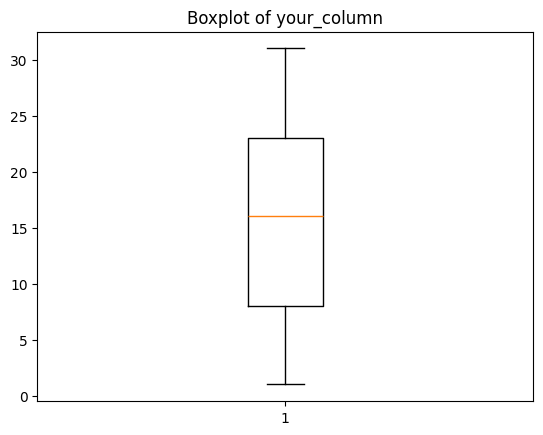

In [111]:
# Example for a single numeric column
plt.boxplot(df['appointment_day'])
plt.title("Boxplot of your_column")
plt.show()

In [ ]:
df.info()

In [142]:
df['service_duration_log'] = np.log1p(df['service_duration'])

Rows with service_duration > 100: 8166
Rows with service_duration <= 100: 189435


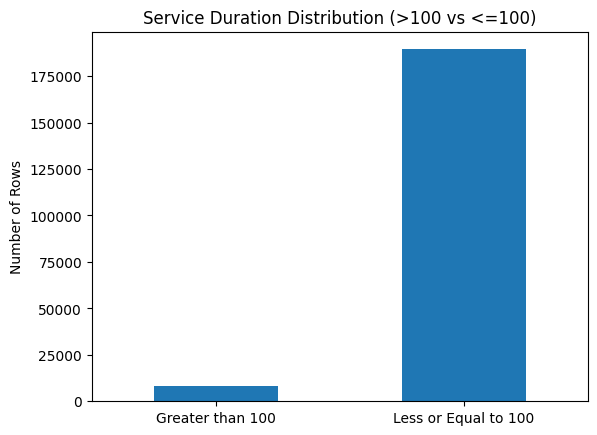

In [160]:
# Count rows greater than 100
greater_100 = df[df['service_duration'] > 100].shape[0]

# Count rows less than or equal to 100
less_equal_100 = df[df['service_duration'] <= 100].shape[0]

print(f"Rows with service_duration > 100: {greater_100}")
print(f"Rows with service_duration <= 100: {less_equal_100}")

# Create a simple bar chart
counts = pd.Series({
    'Greater than 100': greater_100,
    'Less or Equal to 100': less_equal_100
})

counts.plot(kind='bar', rot=0)
plt.title("Service Duration Distribution (>100 vs <=100)")
plt.ylabel("Number of Rows")
plt.show()

Over Sampling 

In [143]:
# Split into two groups
df_majority = df[df['service_duration'] <= 120]
df_minority = df[df['service_duration'] > 130 ]
#df_more_minority = df[df['service_duration'] > 150]

# Oversample minority >= 101
df_minority_oversampled = resample(
    df_minority,
    replace=True,       # sample with replacement
    n_samples=120000, # match majority count
    random_state=42
)

# Oversample more minority - > 150
df_more_minority_oversampled = resample(
    df_minority,
    replace=True,       # sample with replacement
    n_samples=100000, # match majority count
    random_state=42
)

# Combine
df_balanced = pd.concat([df_majority, df_minority_oversampled, ])



print("Before balancing:", df.shape)
print("After balancing:", df_balanced.shape)
print(df_balanced['service_duration'].gt(100).value_counts())


Before balancing: (197601, 25)
After balancing: (314520, 25)
service_duration
False    189435
True     125085
Name: count, dtype: int64


# **Model Training** #

In [144]:
# Define features (X) and target (y)

feature_cols = ['task_id_encoded', 'appointment_year', 'appointment_month', 'appointment_day','appointment_hour', 'appointment_minute' ]

X = df_balanced[feature_cols]
y = df_balanced['service_duration']   # Target variable

#'is_weekend', 'appointment_hour', 'is_peak_hour',
 #   'num_documents', 'queue_number'

In [145]:
print("\nColumns used for features:")
print(feature_cols)


Columns used for features:
['task_id_encoded', 'appointment_year', 'appointment_month', 'appointment_day', 'appointment_hour', 'appointment_minute']


In [146]:
print("\nTarget column stats:")
print(y.describe())


Target column stats:
count    314520.000000
mean         86.123217
std          53.017210
min           5.922487
25%          38.003510
50%          64.803663
75%         138.070160
max         217.635393
Name: service_duration, dtype: float64


In [147]:
#Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [148]:
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (251616, 6) (251616,)
Test set shape: (62904, 6) (62904,)


In [149]:
# Initialize XGBoost Model

xgb_model = XGBRegressor(
    n_estimators=300, #Make this 50000       # number of boosting rounds (trees) +
    learning_rate=0.09,     # step size shrinkage
    max_depth=9,            # maximum tree depth +
    subsample=0.8,          # row sampling
    colsample_bytree=0.8,   # feature sampling
    min_child_weight = 1,   # +
    random_state=42,
    n_jobs=-1
)


In [150]:
#Train the model

xgb_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [151]:
# Save the model
joblib.dump(xgb_model, "task_1.pkl")

print("✅ Model saved as task_1.pkl")

✅ Model saved as task_1.pkl


In [152]:
#Make Predictions from test dataset

y_pred = xgb_model.predict(X_test)

In [153]:
print("First 10 predictions vs actual values:")
results = pd.DataFrame({
    "Actual": y_test.iloc[:10].values,
    "Predicted": y_pred[:10]
})
print(results)


First 10 predictions vs actual values:
       Actual   Predicted
0  157.365324  140.055771
1   96.033877   63.189220
2  171.952297  170.700119
3  180.000000  150.291748
4   57.809799   92.777214
5  141.704173  137.253876
6  143.236600  137.430298
7   37.548602   28.321398
8   23.531252   28.944420
9   27.837118   52.908142


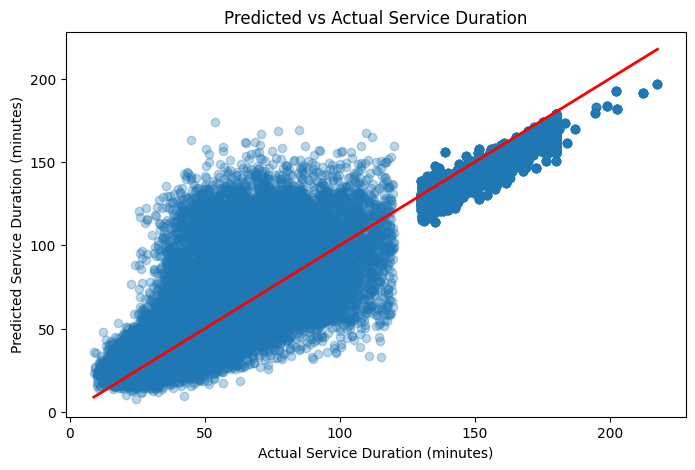

In [154]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linewidth=2)
plt.xlabel("Actual Service Duration (minutes)")
plt.ylabel("Predicted Service Duration (minutes)")
plt.title("Predicted vs Actual Service Duration")
plt.show()


# **Model Evaluation** #

In [155]:
r2 = r2_score(y_test, y_pred)

In [156]:
print("Model Performance on Test Data:")
#print(f"RMSE: {rmse:.2f} minutes")
#print(f"MAE: {mae:.2f} minutes")
print(f"R² Score: {r2:.4f}")

Model Performance on Test Data:
R² Score: 0.9132


# Import task_1.pkl trained model #

In [129]:
#Load trained model

with open("task_1.pkl", "rb") as f:
    task1_model = pickle.load(f)

print("✅ Model loaded successfully")

✅ Model loaded successfully


In [158]:
#Load test dataset
test_df = pd.read_csv("../Data/task1_test_inputs.csv")  # replace with your actual filename

#Create datetime column
test_df['appointment_datetime'] = pd.to_datetime(
    test_df['date'] + " " + test_df['time'], errors="coerce")

#Extract features
test_df['appointment_year'] = test_df['appointment_datetime'].dt.year
test_df['appointment_month'] = test_df['appointment_datetime'].dt.month
test_df['appointment_day'] = test_df['appointment_datetime'].dt.day
test_df['appointment_hour'] = test_df['appointment_datetime'].dt.hour
test_df['appointment_minute'] = test_df['appointment_datetime'].dt.minute

# Load the saved mapping
with open("task_id_mapping.pkl", "rb") as f:
    task_id_mapping = pickle.load(f)

# Reverse the mapping: category -> code
task_id_reverse_mapping = {v: k for k, v in task_id_mapping.items()}

# Apply the same encoding to new data
test_df['task_id_encoded'] = test_df['task_id'].map(task_id_reverse_mapping)


#Select final features
X_test = test_df[['task_id_encoded', 'appointment_year', 'appointment_month',
                  'appointment_day', 'appointment_hour', 'appointment_minute']]


#Predict
y_pred = task1_model.predict(X_test)


# Combine results
results = test_df[['row_id', 'date', 'time', 'task_id']].copy()
results['predicted_service_completion_time'] = y_pred

print("🔹 Predictions for Task 1 (Service Completion Time):")
print(results.head(1000).to_string(index=False))

🔹 Predictions for Task 1 (Service Completion Time):
                                  row_id       date  time  task_id  predicted_service_completion_time
a19eed30dfbab7586131ca2329207b9cff81d5d5 2025-01-01 09:01 TASK-001                          47.019234
8da6066c865c7053bb39092977fc0e513e045159 2025-01-01 09:01 TASK-008                          26.047760
0cec7d70a44a71f0ceb7f78fabd2d0fef1439649 2025-01-01 09:01 TASK-017                          87.243668
de2e5611033bbae4fb959d008455103b2da53e01 2025-01-01 09:02 TASK-007                          25.143507
40736d54ee59e94c3dc5f34127d160db395805a3 2025-01-01 09:05 TASK-016                          43.670883
4c4c7ffa1037ea18780e7bd97fe711dcf0ba8139 2025-01-01 09:07 TASK-005                          34.882633
cad4cbc84f77dc987300be6543744e8f1934e79d 2025-01-01 09:08 TASK-008                          24.787222
b5286469821cb3931dc147a793ee6494fbeb7d6b 2025-01-01 09:10 TASK-008                          22.461763
580186cf9b655bd3c123a1fdf7f786

# CSV File Converter of the task1_test_inputs.csv Predictions #

In [159]:
#Prepare final submission file

submission = pd.DataFrame({
    "row_id": test_df['row_id'],
    "true_processing_time_minutes": y_pred.round().astype(int)  # round + int
})

# Save to CSV
submission.to_csv("task1_predictions.csv", index=False)

print("✅ Submission file saved as task1_predictions.csv")
print(submission.head(20))  # show first 20 rows

✅ Submission file saved as task1_predictions.csv
                                      row_id  true_processing_time_minutes
0   a19eed30dfbab7586131ca2329207b9cff81d5d5                            47
1   8da6066c865c7053bb39092977fc0e513e045159                            26
2   0cec7d70a44a71f0ceb7f78fabd2d0fef1439649                            87
3   de2e5611033bbae4fb959d008455103b2da53e01                            25
4   40736d54ee59e94c3dc5f34127d160db395805a3                            44
5   4c4c7ffa1037ea18780e7bd97fe711dcf0ba8139                            35
6   cad4cbc84f77dc987300be6543744e8f1934e79d                            25
7   b5286469821cb3931dc147a793ee6494fbeb7d6b                            22
8   580186cf9b655bd3c123a1fdf7f78671dacbfd9c                            32
9   b12c460baab67f15db4efd339b4dfa39fd942066                            27
10  f510ca3fa6b6032997dd720d70581ddae2c8914a                            23
11  07d82b65d39cae2701e5b1a1ff98b45cf16449ee       

In [ ]:
#This code block is again added here due to the guideline saying that the .pkl model file importing cell should be at the very end. 
#Load trained model

with open("task_1.pkl", "rb") as f:
    task1_model = pickle.load(f)

print("✅ Model loaded successfully")